In [1]:
!pip install pandas


[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Импортируем зависимости 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join as path_join
import os

In [3]:
power_statistic_dir = path_join(os.getcwd(), "power_consumption_statistics")
classroom_schedule = path_join(os.getcwd(), "classroom_schedule")

In [18]:
power_df = pd.read_csv(path_join(power_statistic_dir, "power_08.02.2023.csv"), sep=";")
power_df = power_df.query("counter == 4101473")
power_df.set_index(["datetime"])

,counter,phase_a,phase_b,phase_c,total
datetime,,,,,
2022-08-31 10:53:33,4101473,166.0,45.0,21.0,232.0
2022-08-31 10:53:33,4101473,166.0,45.0,21.0,232.0
2022-08-31 11:53:37,4101473,191.0,586.0,22.0,799.0
2022-08-31 11:53:37,4101473,191.0,586.0,22.0,799.0
2022-08-31 12:48:23,4101473,204.0,548.0,23.0,775.0
...,...,...,...,...,...
2022-12-31 15:21:06,4101473,178.0,8.0,28.0,214.0
2022-12-31 15:10:19,4101473,219.0,8.0,28.0,255.0
2022-12-31 15:21:06,4101473,178.0,8.0,28.0,214.0


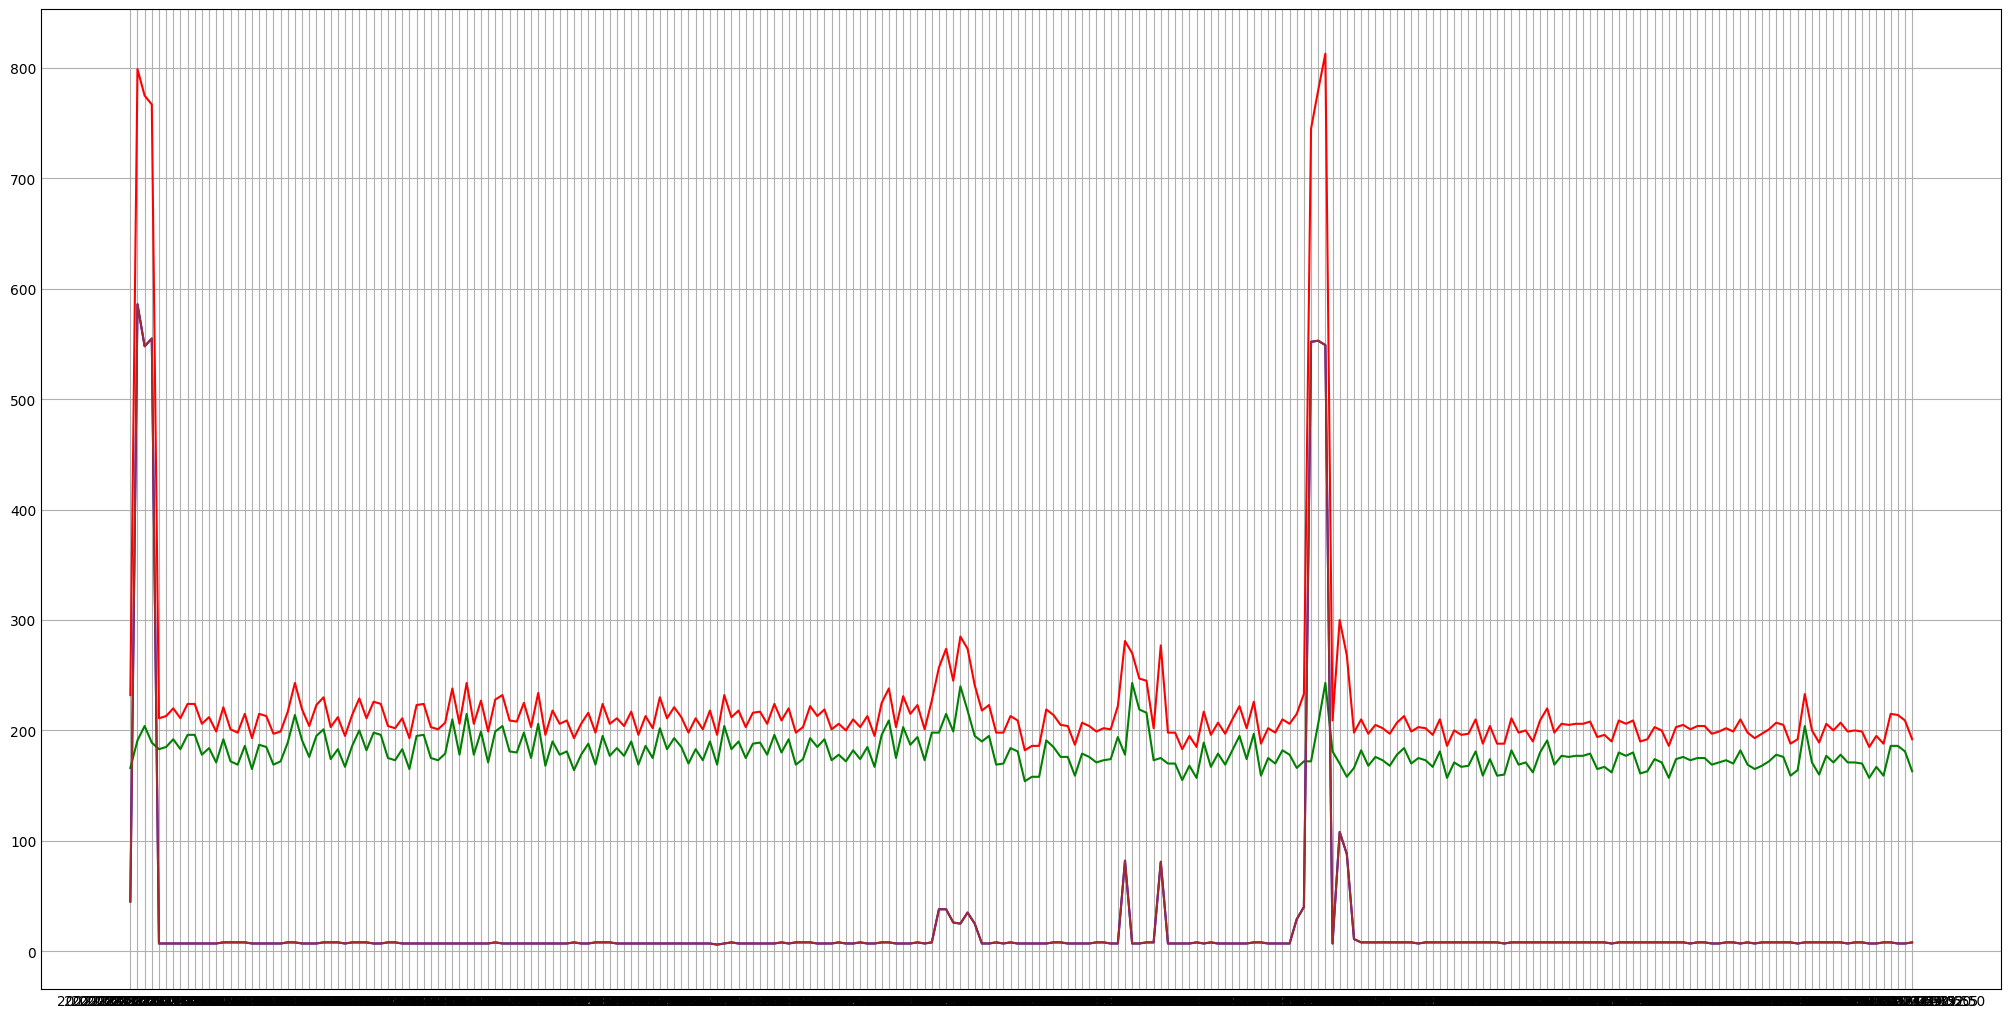

In [34]:
length = 500
x = list(power_df.datetime)[:length]

plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
fig.set_dpi(100)

y = list(power_df.total)[:length]
ax.plot(x, y, linewidth=1.5, color='red')

y = list(power_df.phase_a)[:length]
ax.plot(x, y, linewidth=1.5, color='green')

y = list(power_df.phase_b)[:length]
ax.plot(x, y, linewidth=1.5, color='blue')

y = list(power_df.phase_b)[:length]
ax.plot(x, y, linewidth=1.5, color='brown')

plt.show()